# Construction and meshing of fracture networks

In this tutorial, we will show:

1. How to define fractures and a fracture network in a 3d domain.
2. How to construct a family of meshes that represent the 3d domain, the fractures and their intersections.
3. Assembly of the grids into a `MixedDimensionalGrid` container that stores all grids and the geometric relation between them.

Together, these are the first steps towards creating a simulation model for a mixed-dimensional problem in fractured domains.
For most simulation purposes, the final mixed-dimensional grid is all that is needed. Therefore, we start by showing a shortcut for obtaining a `MixedDimensionalGrid` given a set of fractures, a domain and two mesh size parameters. All these will be described in more detail below.
We also mention that access to methods generating mixed-dimensional grids for a small selection of geometries is available under `pp.grids.standard_grids`.

## Meshing of 2d fractures
Fracture networks in 2d are formed by a set of points, together with their connections. Each column of the 2 x (number of points) point array corresponds to the coordinates of a point. I.e., the x coordinates are in the first and y coordinates in the second row. In the 2 x (number of fractures) connection array, each column defines a fracture by its two endpoints. The entries are indices to point_coordinates, so that fracture i extends from `point_coordinates[:, point_indices[0, i]]` to `point_coordinates[:, point_indices[1, i]]`.

Below, we define two fractures corresponding to the two columns of point_indices:
* The first column defines a horizontal fracture extending from (0, 0) to (2, 0)
* The second column defines a vertical fracture extending from (1, 0) to (1, 1)

In [1]:
import numpy as np
import porepy as pp

# Point coordinates
point_coordinates = np.array([[0, 2, 1, 1], 
                              [0, 0, 0, 1]])

# Point connections as a 2 x num_frac array
point_indices = np.array([[0, 2], 
                          [1, 3]])

# Define a rectangular domain in terms of range in the two dimensions
domain = {'xmin': -2, 'xmax': 3, 'ymin': -2, 'ymax': 3}

We combine the geometry information into a fracture network and produce fracture and matrix meshes, collected in a mixed-dimensional mesh.

In [2]:
# Define a fracture network in 2d
network_2d = pp.FractureNetwork2d(point_coordinates, point_indices, domain)

# Set preferred mesh size close to the fracture and at the boundary (essentially this is a far-field value)
mesh_args = {'mesh_size_frac': 0.3, 'mesh_size_bound': 1.0}

# Generate a mixed-dimensional grid
mdg = network_2d.mesh(mesh_args)

Visualizing the network, we see that the two fractures form a Y (or T) type intersection. The intersection point is identified during meshing and assigned a zero-dimensional mesh. The plot of `mdg` shows how the chosen mesh sizes result in refinement towards the fractures.

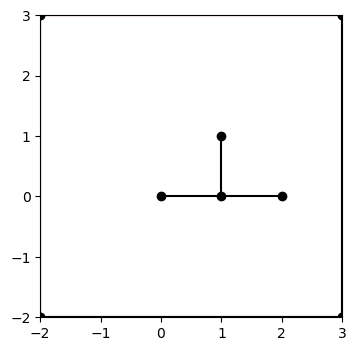

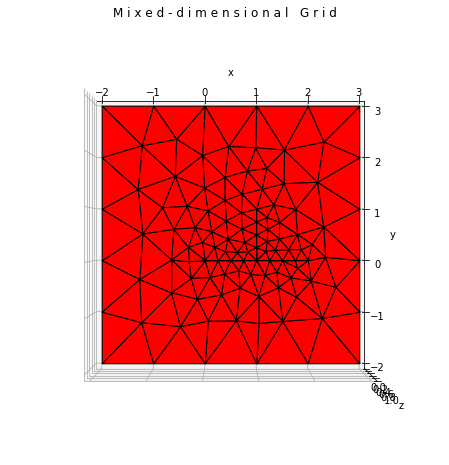

In [3]:
network_2d.plot()
pp.plot_grid(mdg, figsize=(8,8))

## 3d meshing
Fractures in 3d are polygons instead of lines. This makes computations of the geometry quite a bit more difficult, and requires further data structure to store the fractures. Therefore, we define two `PlaneFracture` objects which are used for initialization of the fracture network. This removes the need for a connectivity index specification (point_indices above).

In [4]:
# The fractures are specified by their vertices, which are 3 x num_pts arrays
f_1 = pp.PlaneFracture(np.array([[0, 2, 2.5, 0], 
                                 [0, 0, 1, 1], 
                                 [0, 0, 1, 1]]))
f_2 = pp.PlaneFracture(np.array([[1, 1, 1, 1], 
                                 [-1, 2, 2, -1], 
                                 [-1, -1, 2, 2]]))

# Also define the domain
domain = {'xmin': -1, 'xmax': 3, 'ymin': -2, 'ymax': 3, 'zmin': -1.5, 'zmax': 3}

# Define a 3d FractureNetwork, similar to the 2d one
network = pp.FractureNetwork3d([f_1, f_2], domain=domain)
mesh_args = {'mesh_size_frac': 0.5, 'mesh_size_min': 0.2, 'mesh_size_bound': 1.0}

# Generate the mixed-dimensional mesh
mdg = network.mesh(mesh_args)

## Import filters 
FractureNetworks (2d and 3d) can also be defined directly from files storing their data, see `pp.fracture_importer` for details. 

## Visualization of the mixed-dimensional grid
The set of meshes in the `MixedDimensionalGrid` can be dumped to ParaView by simply writing

In [5]:
pp.Exporter(mdg, 'mixed_dimensional_grid').write_vtu()

Again, some manipulations in ParaView show how the grids on fracture surfaces intersect with each other and with the matrix grid.

<img src='mixed_dimensional_grid.png'  width=600>



# Technical details

This section provides some more detail on the above demonstrated functionality and may be skipped for users with limited interest in technicalities. We focus on the the technicalities related to 3d meshing; in 2d, meshing is relatively simple (still difficult, but 3d is much worse). 

Functionality for fractures and their intersections is provided in the subpackage `porepy.fracs`. In addition to the above method of defining fractures through their vertices, we can also specify the fracture as an ellipsis, approximated as a polygon:

In [6]:
# Specify the fracture center
center = np.array([0.1, 0.3, 0.2])
# The minor and major axis
major_axis = 1.5
minor_axis = 0.5

# Rotate the major axis around the center.
# Note that the angle is measured in radians
major_axis_angle = np.pi/6

# So far, the fracture is located in the xy-plane. To define the incline, specify the strike angle, and the dip angle.
# Note that the dip rotation is carried out after the major_axis rotation (recall rotations are non-commutative).
strike_angle = -np.pi/3
dip_angle = -np.pi/3

# Finally, the number of points used to approximate the ellipsis. 
# This is the only optional parameter; if not specified, 16 points will be used.
num_pt = 12
f_3 = pp.create_elliptic_fracture(center, major_axis, minor_axis, major_axis_angle, strike_angle, dip_angle, num_points=num_pt)

The fractures can be joined into a `FractureNetwork`.

In [7]:
network = pp.FractureNetwork3d([f_1, f_2, f_3])

The `FractureNetwork` class is the base for analysis and manipulation of fracture networks. The functionality is expanding on demand. For the moment, the most interesting feature is the export of the fracture network to ParaView (requires the vtk extension of python installed, see installation instruction):

In [8]:
network.to_file('fracture_network.vtu')

The resulting file can be opened in ParaView.

We have not yet set a boundary for the `FractureNetwork3d`, and effectively for the domain. The boundary is defined as a box, and is imposed in the following way:

In [9]:
# The domain is a dictionary with fields xmin, xmax, etc.
domain = {'xmin': -2, 'xmax': 3, 'ymin': -2, 'ymax': 3, 'zmin': -3, 'zmax': 3}
network.impose_external_boundary(domain)

array([0, 1, 2])

Above, we defined the bounding box to not intersect with the fractures. If the domain would have been smaller, fractures that intersect a face of the box would by default (can be overruled) have been truncated so that they are confined within the bounding box.

## Meshing

Our aim is to create a computational mesh that conforms to the fractures, as well as to their intersections (1d lines, 0d points). For the actual grid construction we rely on Gmsh. However, Gmsh requires that the geometric constraints, that is the fractures, are described as *non-intersecting* polygons. It only takes some thinking to understand why the meshing software would not like to do this themselves; this is a highly challenging task.

PorePy provides functionality for finding intersections between fractures, and splitting them into non-intersecting polygons. Intersections are found by 

In [10]:
network.split_intersections()

### Geometric tolerances and stability of meshing algorithm
A critical concept in meshing of fractured domains is the concept of geometric tolerance: Since we are operating in finite precision aritmethics, two points may or may not be consider equal (or similarly, two lines/planes may or may not intersect), depending on how accurately we consider their representation. At least three concepts come into play here

1. The accuracy of the numerical representation of the objects (accumulated effect of finite precision rounding errors).
2. The accuracy in geological interpretation of fracture data: If the fracture network originates from an interpretation of satellite images, differences measured in centimeters should be treated with some caution.
3. The resolution of the computational grid: If points with a certain distance are considered non-equal, this may also require that we resolve their difference in the mesh. In addition, the mesh generator will use its own concept of geometric tolerance for internal calculations.

In PorePy, we attempt to resolve these issues as follows: The `FractureNetwork3d` (and the corresponding `FractureNetwork2d`) has an attribute `tol` that represents the geometric tolerance used in the calculation of intersections and subsequent splitting of the fractures. If meshing is done with gmsh, the tolerances used in PorePy and gmsh are related. The approach works reasonably well, but for complex configurations of fracture intersections, stability issues can arise. 

### Interaction with gmsh

Now, we want to create grids for the domain, as well as for fractures and fracture intersections. This involves creating a config file for the mesh generator that contains geometry description, including fracture planes and their intersections. The mesh is then created by calling gmsh. The resuling mesh information is read back to python, and `Grid` objects representing the matrix, fractures and fracture intersections are created.



Gmsh is quite flexible in terms of letting the user set/guide the preferred mesh size in different parts of the domain. PorePy tries to adjust to this adapting the specified mesh size to the geometry. From the user side, two parameters must be specified: `mesh_size_frac` gives the target mesh size in the absence of geometric constraints, while `mesh_size_min` gives the minimal mesh size to be specified to Gmsh. Optionally, the boundary may be assigned a separate mesh size through `mesh_size_bound`. What actually happens with the mesh, that is, how Gmsh translates these preferred options into a grid, is another matter. It may take some practice to get this to work properly.


In [11]:
mesh_size_frac = 0.3
mesh_size_min = 0.2
mesh_args = {'mesh_size_frac': mesh_size_frac, 'mesh_size_min': mesh_size_min}

# With the mesh size parameters, we can simply ask the md-grid to mesh itself:
mdg = network.mesh(mesh_args)

# Show basic geometric information on the mixed-dimensional grid
print(mdg)


Mixed-dimensional grid. 
Maximum dimension present: 3 
Minimum dimension present: 1 
Size of highest dimensional grid: Cells: 29335. Nodes: 6146
In lower dimensions: 
3 grids of dimension 2, with in total 533 cells and 336 nodes. 
2 grids of dimension 1, with in total 8 cells and 10 nodes. 
Total number of interfaces: 6
0 interfaces between grids of dimension 3 and 2
3 interfaces between grids of dimension 2 and 1

